In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import importlib
from tqdm import tqdm
from joblib import Parallel, delayed

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, mean_absolute_percentage_error
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPRegressor

pd.set_option('display.max_columns', None)

In [2]:
def evaluate_clf(clf, X, y, train_index, test_index, include_indices=False):
    print(f'Training with {len(train_index)} samples; Testing with {len(test_index)} samples')

    # Get Train/Test Sets
    X_train, X_test = X.iloc[train_index].values, X.iloc[test_index].values
    y_train, y_test = y.iloc[train_index].values, y.iloc[test_index].values

    # Train Model on Selected Fold
    clf.fit(X_train, y_train)
    y_pred = np.clip(clf.predict(X_test), 0, 1)

    # Organize and Return Results
    result = dict(
        instance = clf,
        X_train=X_train,
        X_test=X_test,
        y_train = y_train,
        y_true = y_test,
        y_pred = y_pred,
        acc = clf.score(X_test, y_test),
        mae = mean_absolute_error(y_test, y_pred),
        rmse = mean_squared_error(y_test, y_pred, squared=False),
        rmsle = mean_squared_log_error(y_test, y_pred, squared=False),
    )

    if include_indices:
        result.update({
            'train_indices':train_index,
            'test_indices':test_index
        })

    return result

In [ ]:
X = pd.read_pickle('/content/X_df.pkl')

In [ ]:
X

,dist_euclid,own_speed,target_speed,own_course,target_course
0,10.655910,9.827940,1.206454,109.262214,167.395637
1,3.116042,9.827940,38.151892,109.262214,7.500070
2,10.655910,1.206454,9.827940,167.395637,109.262214
3,10.479444,1.206454,38.151892,167.395637,7.500070
4,3.116042,38.151892,9.827940,7.500070,109.262214
...,...,...,...,...,...
264765,6.178706,1.657704,2.129840,188.961942,219.598516
264766,6.182760,2.129840,1.521905,219.598516,30.599527
264767,6.182760,1.521905,2.129840,30.599527,219.598516
264768,25.225222,1.251172,11.578077,218.256384,100.759199


In [3]:
y = pd.read_pickle('/content/ecriw_df.pkl')

In [4]:
y

,ECRI-W
0,0.233781
1,0.213215
2,0.233781
3,0.214537
4,0.157967
...,...
264765,0.302878
264766,0.156704
264767,0.176238
264768,0.222910


Text(0.5, 0, 'ECRI-W')

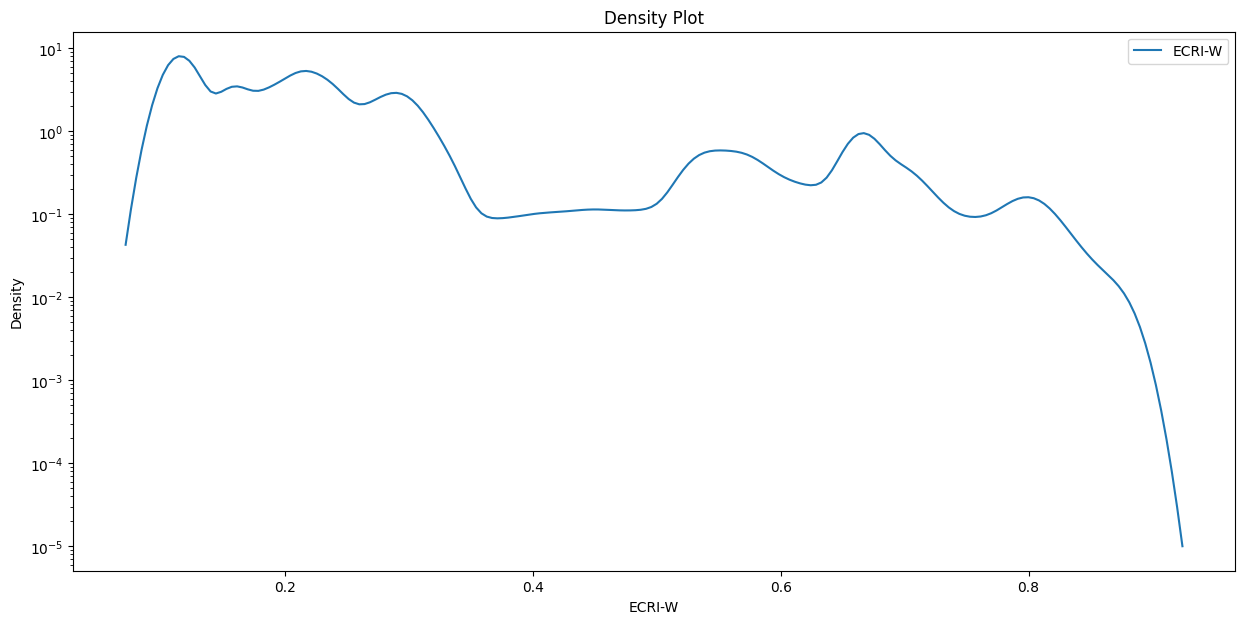

In [5]:
fig, ax = plt.subplots(1, figsize=(15, 7))

sns.kdeplot(data=y, ax=ax)
ax.set_yscale('log')
ax.set_title('Density Plot')
ax.set_xlabel('ECRI-W')

In [8]:
y_range = pd.cut(y['ECRI-W'], bins=np.arange(0, 1.1, .2), right=True, include_lowest=True)

ECRI-W
(-0.001, 0.2]    124097
(0.2, 0.4]       107799
(0.4, 0.6]        14467
(0.6, 0.8]        17013
(0.8, 1.0]         1394
Name: count, dtype: int64


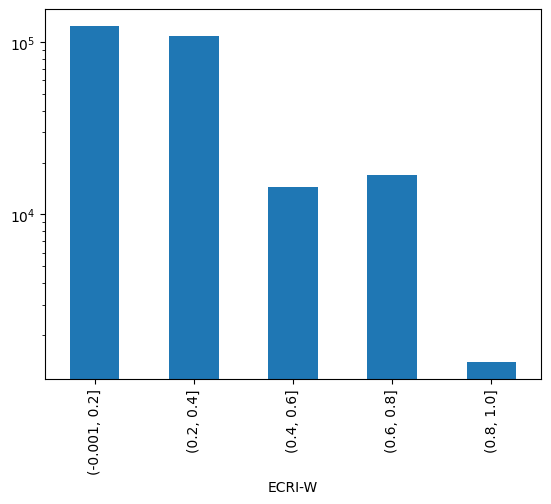

In [9]:
ves_cri_bin_val_counts = y_range.value_counts(sort=False)
print(ves_cri_bin_val_counts)
ax = ves_cri_bin_val_counts.plot.bar()
ax.set_yscale('log')
plt.savefig('y_range.pdf', dpi=300)

SCRE/F

In [ ]:
y_range = y_range.astype('str')

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

In [ ]:
mlp_scre_ours = make_pipeline(
    StandardScaler(),
    MLPRegressor(random_state=10, max_iter=100, hidden_layer_sizes=(256, 32),
                 verbose=True, early_stopping=True, n_iter_no_change=10)
)

mlp_scre_skf_results = Parallel(n_jobs=-1)(delayed(evaluate_clf)(
    mlp_scre_ours, X, y, train_index, test_index, include_indices=True
) for (train_index, test_index) in tqdm(skf.split(X, y_range), total=skf.get_n_splits(X, y_range)))

mlp_scre_skf_results_df = pd.DataFrame(mlp_scre_skf_results)
mlp_scre_skf_results_df

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.53it/s]


,instance,X_train,X_test,y_train,y_true,y_pred,acc,mae,rmse,rmsle,train_indices,test_indices
0,"(StandardScaler(), MLPRegressor(early_stopping...","[[10.655909742429152, 9.82793975857709, 1.2064...","[[10.479443674801505, 1.206453993782595, 38.15...","[[0.2337809092831982], [0.2132153172200814], [...","[[0.21453676665884835], [0.2132153172200814], ...","[0.3008604984325868, 0.20651801943536754, 0.15...",0.288907,0.088783,0.133339,0.097999,"[0, 1, 2, 4, 5, 7, 8, 9, 11, 12, 13, 14, 15, 1...","[3, 6, 10, 18, 26, 43, 44, 51, 53, 57, 59, 61,..."
1,"(StandardScaler(), MLPRegressor(early_stopping...","[[3.1160421413692085, 9.82793975857709, 38.151...","[[10.655909742429152, 9.82793975857709, 1.2064...","[[0.2132153172200814], [0.2337809092831982], [...","[[0.2337809092831982], [0.15796744511169059], ...","[0.24492645909025162, 0.1747391586983159, 0.18...",0.296451,0.090046,0.132630,0.098041,"[1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, ...","[0, 5, 7, 23, 28, 29, 30, 31, 34, 35, 36, 41, ..."
2,"(StandardScaler(), MLPRegressor(early_stopping...","[[10.655909742429152, 9.82793975857709, 1.2064...","[[3.1160421413692085, 38.15189189066979, 9.827...","[[0.2337809092831982], [0.2132153172200814], [...","[[0.15796744511169059], [0.18444344971343127],...","[0.26718514343774874, 0.19019898661340817, 0.3...",0.298024,0.089009,0.132637,0.097767,"[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 13, 14, 15, 16...","[4, 11, 12, 17, 21, 22, 25, 38, 45, 46, 52, 58..."
3,"(StandardScaler(), MLPRegressor(early_stopping...","[[10.655909742429152, 9.82793975857709, 1.2064...","[[20.096848889157272, 1.8709874490746883, 12.1...","[[0.2337809092831982], [0.2132153172200814], [...","[[0.4016543756813015], [0.2132153172200814], [...","[0.31942165894597285, 0.3739569883518431, 0.30...",0.280624,0.090721,0.134109,0.098831,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14...","[9, 16, 19, 24, 32, 33, 37, 40, 50, 56, 77, 80..."
4,"(StandardScaler(), MLPRegressor(early_stopping...","[[10.655909742429152, 9.82793975857709, 1.2064...","[[3.1160421413692085, 9.82793975857709, 38.151...","[[0.2337809092831982], [0.21453676665884835], ...","[[0.2132153172200814], [0.2337809092831982], [...","[0.4087761120258129, 0.23228637958012172, 0.19...",0.294422,0.090546,0.133063,0.098125,"[0, 3, 4, 5, 6, 7, 9, 10, 11, 12, 16, 17, 18, ...","[1, 2, 8, 13, 14, 15, 20, 27, 39, 48, 60, 64, ..."


In [ ]:
mlp_scre_skf_results_df.loc[:, 'r2_score'] = mlp_scre_skf_results_df.apply(lambda l: sklearn.metrics.r2_score(l.y_true, l.y_pred), axis=1)

In [ ]:
mlp_scre_skf_results_df

,instance,X_train,X_test,y_train,y_true,y_pred,acc,mae,rmse,rmsle,train_indices,test_indices,r2_score
0,"(StandardScaler(), MLPRegressor(early_stopping...","[[10.655909742429152, 9.82793975857709, 1.2064...","[[10.479443674801505, 1.206453993782595, 38.15...","[[0.2337809092831982], [0.2132153172200814], [...","[[0.21453676665884835], [0.2132153172200814], ...","[0.3008604984325868, 0.20651801943536754, 0.15...",0.288907,0.088783,0.133339,0.097999,"[0, 1, 2, 4, 5, 7, 8, 9, 11, 12, 13, 14, 15, 1...","[3, 6, 10, 18, 26, 43, 44, 51, 53, 57, 59, 61,...",0.288907
1,"(StandardScaler(), MLPRegressor(early_stopping...","[[3.1160421413692085, 9.82793975857709, 38.151...","[[10.655909742429152, 9.82793975857709, 1.2064...","[[0.2132153172200814], [0.2337809092831982], [...","[[0.2337809092831982], [0.15796744511169059], ...","[0.24492645909025162, 0.1747391586983159, 0.18...",0.296451,0.090046,0.132630,0.098041,"[1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, ...","[0, 5, 7, 23, 28, 29, 30, 31, 34, 35, 36, 41, ...",0.296451
2,"(StandardScaler(), MLPRegressor(early_stopping...","[[10.655909742429152, 9.82793975857709, 1.2064...","[[3.1160421413692085, 38.15189189066979, 9.827...","[[0.2337809092831982], [0.2132153172200814], [...","[[0.15796744511169059], [0.18444344971343127],...","[0.26718514343774874, 0.19019898661340817, 0.3...",0.298024,0.089009,0.132637,0.097767,"[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 13, 14, 15, 16...","[4, 11, 12, 17, 21, 22, 25, 38, 45, 46, 52, 58...",0.298024
3,"(StandardScaler(), MLPRegressor(early_stopping...","[[10.655909742429152, 9.82793975857709, 1.2064...","[[20.096848889157272, 1.8709874490746883, 12.1...","[[0.2337809092831982], [0.2132153172200814], [...","[[0.4016543756813015], [0.2132153172200814], [...","[0.31942165894597285, 0.3739569883518431, 0.30...",0.280624,0.090721,0.134109,0.098831,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14...","[9, 16, 19, 24, 32, 33, 37, 40, 50, 56, 77, 80...",0.280624
4,"(StandardScaler(), MLPRegressor(early_stopping...","[[10.655909742429152, 9.82793975857709, 1.2064...","[[3.1160421413692085, 9.82793975857709, 38.151...","[[0.2337809092831982], [0.21453676665884835], ...","[[0.2132153172200814], [0.2337809092831982], [...","[0.4087761120258129, 0.23228637958012172, 0.19...",0.294422,0.090546,0.133063,0.098125,"[0, 3, 4, 5, 6, 7, 9, 10, 11, 12, 16, 17, 18, ...","[1, 2, 8, 13, 14, 15, 20, 27, 39, 48, 60, 64, ...",0.294422


In [ ]:
mlp_scre_skf_results_df.groupby(level=0).mean(numeric_only=True)

,acc,mae,rmse,rmsle,r2_score
0,0.288907,0.088783,0.133339,0.097999,0.288907
1,0.296451,0.090046,0.132630,0.098041,0.296451
2,0.298024,0.089009,0.132637,0.097767,0.298024
3,0.280624,0.090721,0.134109,0.098831,0.280624
4,0.294422,0.090546,0.133063,0.098125,0.294422


In [ ]:
mlp_scre_skf_results_df.mean(numeric_only=True)

acc         0.291686
mae         0.089821
rmse        0.133156
rmsle       0.098153
r2_score    0.291686
dtype: float64

In [ ]:
mlp_scre_skf_results_df.rmse.mean()

0.1331557259149266